# Arabic Auto-Complete System

## Imports

In [1]:
import os  
import re   
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.model_selection import train_test_split

## Text Cleaning Function

In [2]:
def clean_arabic_text(text):
    # 1. Remove tashkeel including tatweel 
    text = re.sub(r'[ً-ْـ]', '', text)
    
    # 2. Remove punctuation and special characters (keeping Arabic letters, numbers, and basic punctuation)
    text = re.sub(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF\s٠-٩۰-۹.,،؛؟!]', ' ', text)

    # 3. Normalize Arabic characters
    text = re.sub(r'[آأإ]', 'ا', text)  
    text = re.sub(r'ى', 'ي', text)     
    text = re.sub(r'ة', 'ه', text)     

    # 4. Remove English letters and Western digits
    text = re.sub(r'[a-zA-Z]', '', text)
    text = re.sub(r'[0-9]', '', text)

    # 5. Normalize Arabic punctuation to standard ones
    text = text.replace('؟', '?')  # Arabic question mark
    text = text.replace('،', ',')  # Arabic comma
    text = text.replace('؛', ';')  # Arabic semicolon

    # 6. Remove extra spaces and newlines
    text = re.sub(r'\s+', ' ', text).strip()

    # 7. Remove repeated characters 
    text = re.sub(r'(.)\1+', r'\1', text)

    return text


## Data Loading and Cleaning

In [3]:
file_names = ['file1.txt', 'file2.txt', 'file3.txt', 'file4.txt']  # data files
all_clean_lines = []  

for file in file_names:
    with open(file, 'r', encoding='utf-8') as f:
        lines = f.readlines()  
        for line in lines:
            if 'NULL' in line:
                continue  # skip lines with the word NULL
            clean_line = clean_arabic_text(line)
            if clean_line:  # don't save empty lines
                all_clean_lines.append(clean_line)


##  Save Cleaned Data


In [4]:
with open('cleaned_data.txt', 'w', encoding='utf-8') as f:
    for line in all_clean_lines:
        f.write(line + '\n')

## Read the data

In [5]:
with open('cleaned_data.txt', 'r', encoding='utf-8') as file:
    texts = file.readlines()

## Info about the data

In [6]:
analysis = {
        'total_texts': len(texts),
        'avg_length': sum(len(text.split()) for text in texts) / len(texts),
        'min_length': min(len(text.split()) for text in texts),
        'max_length': max(len(text.split()) for text in texts),
        'total_words': sum(len(text.split()) for text in texts),
        'sample_texts': texts[:3]
    }
    
# Word frequency analysis (top 20 most common words)
word_freq = {}
for text in texts:
    for word in text.split():
        word_freq[word] = word_freq.get(word, 0) + 1

analysis['top_words'] = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
print(f"Total texts: {analysis['total_texts']}")
print(f"Average text length: {analysis['avg_length']:.2f} words")
print(f"Min text length: {analysis['min_length']} words")
print(f"Max text length: {analysis['max_length']} words")
print(f"Total words in dataset: {analysis['total_words']}")

print("\nSample texts:")
for i, text in enumerate(analysis['sample_texts']):
    print(f"{i+1}. {text.strip()}")

Total texts: 7904
Average text length: 5.45 words
Min text length: 1 words
Max text length: 43 words
Total words in dataset: 43071

Sample texts:
1. اهنئ الدكتور احمد جمال الدين, القيادي بحزب مصر, بمناسبه صدور اولي روايه
2. امير عيد هو الي فعلا يتقال عليه ستريكر صريح
3. الصداقه تزرع الحياه ازهارا


## Tokenization and Sequence Preparation

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
total_words = len(tokenizer.word_index) + 1
print(f"\nTotal unique words: {total_words}")
input_sequences = []
for text in texts:
    token_list = tokenizer.texts_to_sequences([text])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


Total unique words: 7868


## Padding Sequences

In [8]:
max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
print("\nSample padded sequences:")
print(input_sequences[:3])



Sample padded sequences:
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0 3117  378]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0 3117  378  547]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0 3117  378  547  255]]


## Split Features (X) and Labels (y)

In [9]:
X = input_sequences[:, :-1]
y = input_sequences[:, -1]
y = to_categorical(y, num_classes=total_words)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")





Training data shape: (28064, 41)
Validation data shape: (7017, 41)


##  Build and Train the Model

In [10]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len - 1))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(total_words, activation='softmax'))

# Compile the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.01), 
    metrics=['accuracy']
)
    

# Train the model
history = model.fit(X_train, y_train,
        epochs=30,
      batch_size=512,
      validation_data=(X_val, y_val),
        verbose=1)



2025-05-13 06:26:52.127813: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
55/55 [==============================] - 138s 2s/step - loss: 8.2930 - accuracy: 0.0281 - val_loss: 7.9377 - val_accuracy: 0.0296
Epoch 2/30
55/55 [==============================] - 110s 2s/step - loss: 7.6242 - accuracy: 0.0290 - val_loss: 7.8193 - val_accuracy: 0.0288
Epoch 3/30
55/55 [==============================] - 136s 2s/step - loss: 7.2827 - accuracy: 0.0288 - val_loss: 7.6093 - val_accuracy: 0.0269
Epoch 4/30
55/55 [==============================] - 127s 2s/step - loss: 6.9069 - accuracy: 0.0326 - val_loss: 7.3598 - val_accuracy: 0.0351
Epoch 5/30
55/55 [==============================] - 146s 3s/step - loss: 6.4611 - accuracy: 0.0441 - val_loss: 7.0646 - val_accuracy: 0.0463
Epoch 6/30
55/55 [==============================] - 135s 2s/step - loss: 5.9752 - accuracy: 0.0648 - val_loss: 6.7448 - val_accuracy: 0.0650
Epoch 7/30
55/55 [==============================] - 135s 2s/step - loss: 5.4887 - accuracy: 0.0923 - val_loss: 6.4144 - val_accuracy: 0.0961
Epoch 8/30
55

## Model Evaluation

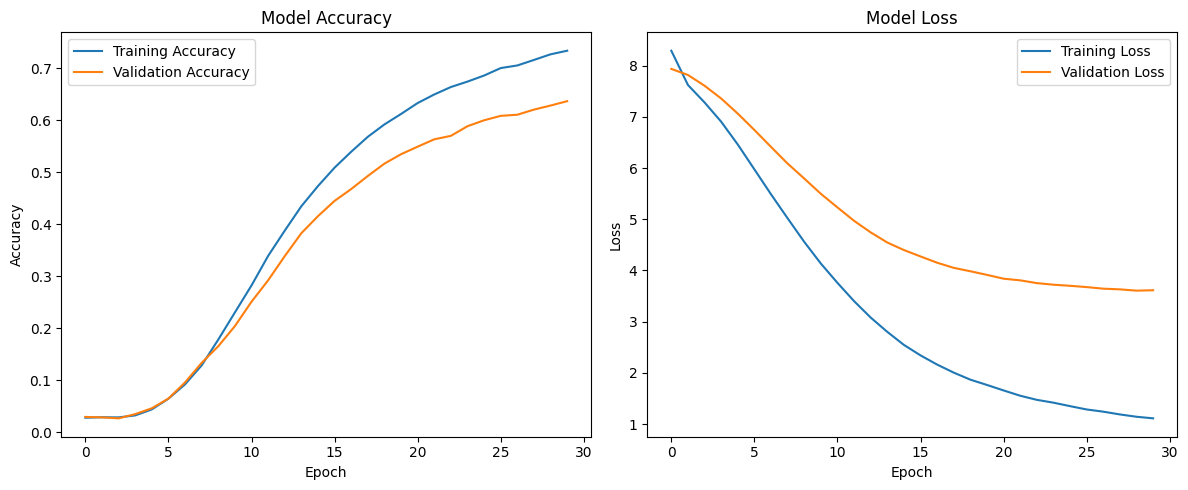

In [11]:
evaluation = {
    'final_train_accuracy': history.history['accuracy'][-1],
    'final_val_accuracy': history.history['val_accuracy'][-1],
    'final_train_loss': history.history['loss'][-1],
    'final_val_loss': history.history['val_loss'][-1],
    'best_val_accuracy': max(history.history['val_accuracy']),
    'best_epoch': history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
}

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('model_performance.png')
plt.show()

## Save the model

In [12]:
def save_model_and_tokenizer(model, tokenizer, model_path='arabic_autocomplete_model.h5', tokenizer_path='arabic_tokenizer.npy'):
    model.save(model_path)
    print(f"Model saved to: {model_path}")
    
    # Save the tokenizer - using numpy to save dictionary
    tokenizer_json = tokenizer.to_json()
    with open(tokenizer_path, 'w', encoding='utf-8') as f:
        f.write(tokenizer_json)
    print(f"Tokenizer saved to: {tokenizer_path}")
    
    # Save model configuration for future reference
    model_config = {
        'max_sequence_len': max_sequence_len,
        'total_words': total_words,
        'embedding_dim': 100,
        'lstm_units': 128,
        'dropout_rate': 0.2
    }
    
    np.save('model_config.npy', model_config)
    print("Model configuration saved to: model_config.npy")

save_model_and_tokenizer(model, tokenizer)

Model saved to: arabic_autocomplete_model.h5
Tokenizer saved to: arabic_tokenizer.npy
Model configuration saved to: model_config.npy


## Load the model

In [13]:
def load_model_and_tokenizer(model_path='arabic_autocomplete_model.h5', tokenizer_path='arabic_tokenizer.npy', config_path='model_config.npy'):
    from tensorflow.keras.models import load_model
    from tensorflow.keras.preprocessing.text import tokenizer_from_json
    import numpy as np
    # Load the model
    model = load_model(model_path)
    print(f"Model loaded from: {model_path}")
    
    # Load the tokenizer
    with open(tokenizer_path, 'r', encoding='utf-8') as f:
        tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)
    print(f"Tokenizer loaded from: {tokenizer_path}")
    
    # Load model configuration
    model_config = np.load(config_path, allow_pickle=True).item()
    print("Model configuration loaded")
    
    return model, tokenizer, model_config
model, tokenizer, model_config=load_model_and_tokenizer()

Model loaded from: arabic_autocomplete_model.h5
Tokenizer loaded from: arabic_tokenizer.npy
Model configuration loaded


##  Predection Function

In [14]:
def predict_sequence(model, tokenizer, start_word, next_words, max_len):
    result = start_word
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([result])[0]
        token_list = pad_sequences([token_list], maxlen=max_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)[0]
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                result += " " + word
                break
    return result

# Try an example
start_word = "دي"
next_words = 2
generated_text = predict_sequence(model, tokenizer, start_word, next_words, max_sequence_len)
print("النص الناتج:", generated_text)

النص الناتج: دي اخلاق السلف


##  Arabic Complete system's GUI

In [ ]:
import tkinter as tk
from tkinter import ttk, scrolledtext
import numpy as np
from PIL import Image, ImageTk
import os
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences  

PRIMARY_COLOR = "#2196F3"
SECONDARY_COLOR = "#FFC107"
BG_COLOR = "#F5F5F5"
TEXT_COLOR = "#212121"
ACCENT_COLOR = "#E3F2FD"

HEADER_FONT = ("Segoe UI", 24, "bold")
LABEL_FONT = ("Segoe UI", 12)
BUTTON_FONT = ("Segoe UI", 12, "bold")
TEXT_FONT = ("Segoe UI", 12)

class ArabicAutocompleteGUI:
    def __init__(self, root):
        self.root = root
      
        
        self.root.title("نظام الإكمال التلقائي للغة العربية")
        self.root.geometry("800x600")
        self.root.configure(bg=BG_COLOR)
        
        self.main_frame = tk.Frame(self.root, bg=BG_COLOR)
        self.main_frame.pack(fill=tk.BOTH, expand=True, padx=20, pady=20)
        
        self.setup_ui()
        
    def setup_ui(self):
        header_frame = tk.Frame(self.main_frame, bg=PRIMARY_COLOR, height=60)
        header_frame.pack(fill=tk.X, pady=(0, 20))
        
        header_label = tk.Label(
            header_frame, 
            text="نظام الإكمال التلقائي للغة العربية", 
            font=HEADER_FONT, 
            bg=PRIMARY_COLOR, 
            fg="white",
            pady=10
        )
        header_label.pack()
        
        input_frame = tk.Frame(self.main_frame, bg=BG_COLOR)
        input_frame.pack(fill=tk.X, pady=10)

        input_label = tk.Label(
            input_frame, 
            text="أدخل النص:", 
            font=LABEL_FONT, 
            bg=BG_COLOR, 
            fg=TEXT_COLOR,
            anchor="e"
        )
        input_label.pack(anchor="e", padx=5, pady=5)

        self.input_text = tk.Entry(
            input_frame, 
            font=TEXT_FONT, 
            bg="white", 
            fg=TEXT_COLOR,
            bd=1,
            relief=tk.SOLID,
            justify="right"
        )
        self.input_text.pack(fill=tk.X, padx=10, pady=5, ipadx=15, ipady=8)
        
        options_frame = tk.Frame(self.main_frame, bg=BG_COLOR)
        options_frame.pack(fill=tk.X, pady=10)
        
        words_label = tk.Label(
            options_frame, 
            text="عدد الكلمات للتنبؤ:", 
            font=LABEL_FONT, 
            bg=BG_COLOR, 
            fg=TEXT_COLOR
        )
        words_label.pack(side=tk.RIGHT, padx=5)
        
        self.words_var = tk.StringVar(value="5")
        words_spinner = tk.Spinbox(
            options_frame, 
            from_=1, 
            to=10, 
            textvariable=self.words_var,
            width=5,
            font=TEXT_FONT
        )
        words_spinner.pack(side=tk.RIGHT, padx=5)
        
        generate_button = tk.Button(
            options_frame, 
            text="توليد النص", 
            font=BUTTON_FONT, 
            bg=SECONDARY_COLOR, 
            fg=TEXT_COLOR,
            padx=15,
            pady=5,
            relief=tk.RAISED,
            command=self.generate_text
        )
        generate_button.pack(side=tk.LEFT, padx=5)
        
        clear_button = tk.Button(
            options_frame, 
            text="مسح", 
            font=BUTTON_FONT, 
            bg=PRIMARY_COLOR, 
            fg="white",
            padx=15,
            pady=5,
            relief=tk.RAISED,
            command=self.clear_text
        )
        clear_button.pack(side=tk.LEFT, padx=5)
        
        results_frame = tk.Frame(self.main_frame, bg=ACCENT_COLOR, bd=1, relief=tk.SOLID)
        results_frame.pack(fill=tk.BOTH, expand=True, pady=10)
        
        results_label = tk.Label(
            results_frame, 
            text="النص الناتج:", 
            font=LABEL_FONT, 
            bg=ACCENT_COLOR, 
            fg=TEXT_COLOR,
            anchor="e"
        )
        results_label.pack(anchor="e", padx=10, pady=5)
        
        self.results_text = scrolledtext.ScrolledText(
            results_frame, 
            font=TEXT_FONT, 
            bg="white", 
            fg=TEXT_COLOR,
            wrap=tk.WORD,
            height=10
        )
        self.results_text.pack(fill=tk.BOTH, expand=True, padx=10, pady=(0, 10))
        self.results_text.tag_configure("rtl", justify="right")
        
    def generate_text(self):
        start_word = self.input_text.get().strip()
        if not start_word:
            return
        
        try:
            next_words = int(self.words_var.get())
            if next_words < 1:
                next_words = 1
            elif next_words > 20:
                next_words = 20
        except ValueError:
            next_words = 5
            self.words_var.set("5")
        
        try:
            generated_text = predict_sequence(model, tokenizer, start_word, next_words, max_sequence_len)
            self.results_text.delete(1.0, tk.END)
            self.results_text.insert(tk.END, generated_text, "rtl")
        except Exception as e:
            print("Error:", e)  
    
    def clear_text(self):
        self.input_text.delete(0, tk.END)
        self.results_text.delete(1.0, tk.END)
    
    


root = tk.Tk()
app = ArabicAutocompleteGUI(root)
root.mainloop()